In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 147.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=b1099fbaa2a702ed1589287be72ab0f6cff3a1f219d87ed93d05584eb876e417
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

import kagglehub

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Path to dataset files:", path)

for root, dirs, files in os.walk(path):
    print(root)
    break
print(os.listdir(path))

base_path = "/kaggle/input/kermany2018"

print("OCT2017 :", os.listdir(os.path.join(base_path, "OCT2017 ")))
print("oct2017 :", os.listdir(os.path.join(base_path, "oct2017")))

DATA_ROOT = "/kaggle/input/kermany2018/OCT2017 "

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")

print("Train classes:", os.listdir(train_dir))
print("Val classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))

Using device: cuda
Using Colab cache for faster access to the 'kermany2018' dataset.
Path to dataset files: /kaggle/input/kermany2018
/kaggle/input/kermany2018
['OCT2017 ', 'oct2017']
OCT2017 : ['val', 'test', 'train']
oct2017 : ['OCT2017 ', '__MACOSX']
Train classes: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Val classes: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test classes: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


Prepared dataset and fixed random seeds.

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
val_ds   = datasets.ImageFolder(val_dir, transform=test_transform)
test_ds  = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print("Classes:", train_ds.classes)
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))


Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Train size: 83484
Val size: 32
Test size: 968


Load and pre-process image in the dataset.

In [4]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device, epoch, num_epochs):
    model.train()
    running_loss = 0.0

    pbar = tqdm(loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    return running_loss / len(loader)


Progress bar when model trainning.

In [5]:
def evaluate_preds(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    pbar =tqdm(
        loader,
        desc=f"Epoch [{epoch+1}/{num_epochs}]",
        leave=False
    )

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels


In [6]:
def evaluate_metrics(model, loader, device):
    preds, labels = evaluate_preds(model, loader, device)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return acc, f1, preds, labels


Gerenal eval and pred fucntions

In [7]:
def build_resnet18(num_classes=4):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def build_efficientnet_b0(num_classes=4):
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(
        model.classifier[1].in_features, num_classes
    )
    return model

def build_mobilenet_v2(num_classes=4):
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(
        model.classifier[1].in_features, num_classes
    )
    return model


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
criterion = nn.CrossEntropyLoss()

In [9]:
model_resnet = build_resnet18().to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    loss = train_one_epoch(
        model_resnet, train_loader, optimizer,
        criterion, device, epoch, num_epochs
    )
    print(f"[ResNet-18] Epoch {epoch+1} Train Loss: {loss:.4f}")

resnet_acc, resnet_f1, resnet_pred, resnet_true = evaluate_metrics(
    model_resnet, test_loader, device
)

print("ResNet-18 Test Acc:", resnet_acc)
print("ResNet-18 Test Macro-F1:", resnet_f1)

torch.save(model_resnet.state_dict(), "resnet18_oct.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]


[ResNet-18] Epoch 1 Train Loss: 0.1650


[ResNet-18] Epoch 2 Train Loss: 0.1088


[ResNet-18] Epoch 3 Train Loss: 0.0876


[ResNet-18] Epoch 4 Train Loss: 0.0735


[ResNet-18] Epoch 5 Train Loss: 0.0618


ResNet-18 Test Acc: 0.9886363636363636
ResNet-18 Test Macro-F1: 0.9886525844973836


In [10]:
model_eff = build_efficientnet_b0().to(device)
optimizer = optim.Adam(model_eff.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    loss = train_one_epoch(
        model_eff, train_loader, optimizer,
        criterion, device, epoch, num_epochs
    )
    print(f"[EfficientNet-B0] Epoch {epoch+1} Train Loss: {loss:.4f}")

eff_acc, eff_f1, eff_pred, eff_true = evaluate_metrics(
    model_eff, test_loader, device
)

print("EfficientNet-B0 Test Acc:", eff_acc)
print("EfficientNet-B0 Test Macro-F1:", eff_f1)

torch.save(model_eff.state_dict(), "efficientnet_b0_oct.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 227MB/s]


[EfficientNet-B0] Epoch 1 Train Loss: 0.1872


[EfficientNet-B0] Epoch 2 Train Loss: 0.1039


[EfficientNet-B0] Epoch 3 Train Loss: 0.0805


[EfficientNet-B0] Epoch 4 Train Loss: 0.0672


[EfficientNet-B0] Epoch 5 Train Loss: 0.0556


EfficientNet-B0 Test Acc: 0.9948347107438017
EfficientNet-B0 Test Macro-F1: 0.9948341594408938


In [11]:
model_mobilenet = build_mobilenet_v2().to(device)
optimizer = optim.Adam(model_mobilenet.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    loss = train_one_epoch(
        model_mobilenet, train_loader, optimizer,
        criterion, device, epoch, num_epochs
    )
    print(f"[MobileNetV2] Epoch {epoch+1} Train Loss: {loss:.4f}")

mobile_acc, mobile_f1, mobile_pred, mobile_true = evaluate_metrics(
    model_mobilenet, test_loader, device
)

print("MobileNetV2 Test Acc:", mobile_acc)
print("MobileNetV2 Test Macro-F1:", mobile_f1)

torch.save(model_mobilenet.state_dict(), "mobilenet_v2_oct.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 220MB/s]


[MobileNetV2] Epoch 1 Train Loss: 0.1788


[MobileNetV2] Epoch 2 Train Loss: 0.1126


[MobileNetV2] Epoch 3 Train Loss: 0.0933


[MobileNetV2] Epoch 4 Train Loss: 0.0782


[MobileNetV2] Epoch 5 Train Loss: 0.0681


MobileNetV2 Test Acc: 0.9896694214876033
MobileNetV2 Test Macro-F1: 0.9896650096516852


In [12]:
import pandas as pd

results = pd.DataFrame([
    {"Model": "ResNet-18",      "Test Acc": resnet_acc, "Macro-F1": resnet_f1},
    {"Model": "EfficientNet-B0","Test Acc": eff_acc,    "Macro-F1": eff_f1},
    {"Model": "MobileNetV2",    "Test Acc": mobile_acc, "Macro-F1": mobile_f1},
])

results


,Model,Test Acc,Macro-F1
0,ResNet-18,0.988636,0.988653
1,EfficientNet-B0,0.994835,0.994834
2,MobileNetV2,0.989669,0.989665


In [13]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [14]:
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img


In [15]:
def run_gradcam(
    model,
    target_layer,
    image_tensor,
    class_idx=None,
    title=""
):
    model.eval()

    cam = GradCAM(
        model=model,
        target_layers=[target_layer],
    )

    grayscale_cam = cam(
        input_tensor=image_tensor,
        targets=None if class_idx is None else [class_idx]
    )[0]

    img = denormalize(image_tensor[0])
    cam_img = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(4, 4))
    plt.imshow(cam_img)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [16]:
model_resnet = build_resnet18().to(device)
model_resnet.load_state_dict(torch.load("resnet18_oct.pth", map_location=device))
model_resnet.eval()
target_layer_resnet = model_resnet.layer4[-1]

model_eff = build_efficientnet_b0().to(device)
model_eff.load_state_dict(torch.load("efficientnet_b0_oct.pth", map_location=device))
model_eff.eval()
target_layer_eff = model_eff.features[-1]

model_mobile = build_mobilenet_v2().to(device)
model_mobile.load_state_dict(torch.load("mobilenet_v2_oct.pth", map_location=device))
model_mobile.eval()
target_layer_mobile = model_mobile.features[-1]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most u

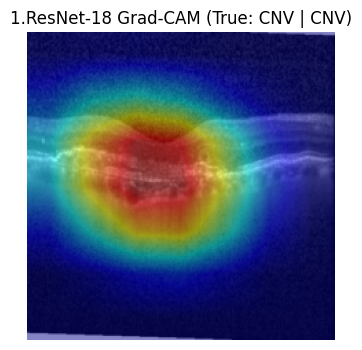

In [17]:
#pick one correct
test_pred, test_true = evaluate_preds(
    model_resnet,
    test_loader,
    device
)
right_idx = (test_pred == test_true).nonzero(as_tuple=True)[0][0].item()
idx = 0
img, label = test_ds[idx]
pred_label = test_pred[right_idx].item()
input_tensor = img.unsqueeze(0).to(device)
class_names = train_ds.classes
run_gradcam(
    model_resnet,
    target_layer_resnet,
    input_tensor,
    title=f"1.ResNet-18 Grad-CAM ({class_names[label] == class_names[pred_label]}: {class_names[label]} | {class_names[pred_label]})"
)


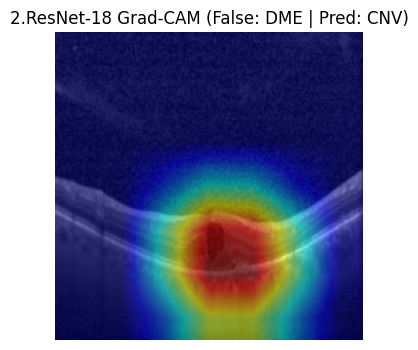

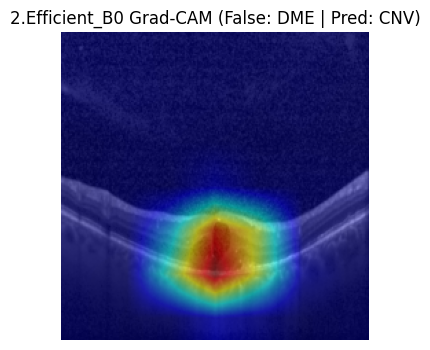

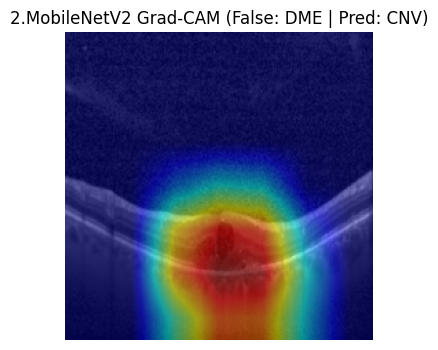

In [18]:
#Pick one wrong across 3 models.
test_pred, test_true = evaluate_preds(
    model_resnet,
    test_loader,
    device
)

error_idx = (test_pred != test_true).nonzero(as_tuple=True)[0][0].item()

img, label = test_ds[error_idx]
pred_label = test_pred[error_idx].item()

input_tensor = img.unsqueeze(0).to(device)

run_gradcam(
    model_resnet,
    target_layer_resnet,
    input_tensor,
    title=f"2.ResNet-18 Grad-CAM ({class_names[label] == class_names[pred_label]}: {class_names[label]} | Pred: {class_names[pred_label]})"
)


test_pred, test_true = evaluate_preds(
    model_eff,
    test_loader,
    device
)


run_gradcam(
    model_eff,
    target_layer_eff,
    input_tensor,
    title=f"2.Efficient_B0 Grad-CAM ({class_names[label] == class_names[pred_label]}: {class_names[label]} | Pred: {class_names[pred_label]})"
)


test_pred, test_true = evaluate_preds(
    model_mobile,
    test_loader,
    device
)


run_gradcam(
    model_mobile,
    target_layer_mobile,
    input_tensor,
    title=f"2.MobileNetV2 Grad-CAM ({class_names[label] == class_names[pred_label]}: {class_names[label]} | Pred: {class_names[pred_label]})"
)

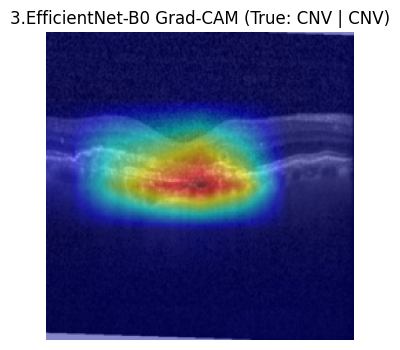

In [19]:
# pick correct in efficient
idx = 0
img, label = test_ds[idx]

input_tensor = img.unsqueeze(0).to(device)
class_names = train_ds.classes
run_gradcam(
    model_eff,
    target_layer_eff,
    input_tensor,
    title=f"3.EfficientNet-B0 Grad-CAM ({class_names[label] == class_names[pred_label]}: {class_names[label]} | {class_names[pred_label]})"
)

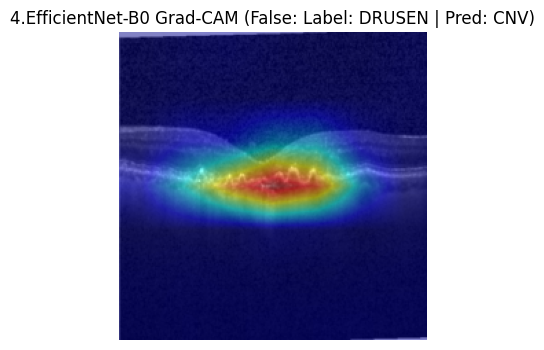

In [20]:
# pick wrong in efficient
test_pred, test_true = evaluate_preds(
    model_eff,
    test_loader,
    device
)

error_idx = (test_pred != test_true).nonzero(as_tuple=True)[0][0].item()

img, label = test_ds[error_idx]
pred_label = test_pred[error_idx].item()

input_tensor = img.unsqueeze(0).to(device)

run_gradcam(
    model_eff,
    target_layer_eff,
    input_tensor,
    title=f"4.EfficientNet-B0 Grad-CAM ({class_names[label] == class_names[pred_label]}: Label: {class_names[label]} | Pred: {class_names[pred_label]})"
)


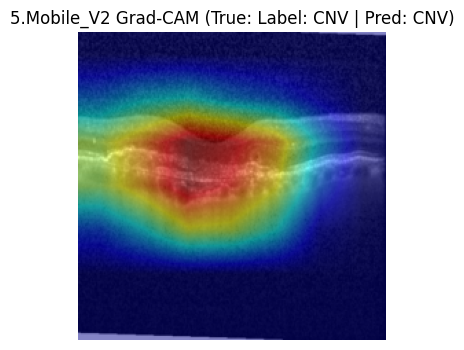

In [21]:
# pick correct in Mobile
idx = 0
img, label = test_ds[idx]

input_tensor = img.unsqueeze(0).to(device)
class_names = train_ds.classes
run_gradcam(
    model_mobile,
    target_layer_mobile,
    input_tensor,
    title=f"5.Mobile_V2 Grad-CAM ({class_names[label] == class_names[pred_label]}: Label: {class_names[label]} | Pred: {class_names[pred_label]})"
)

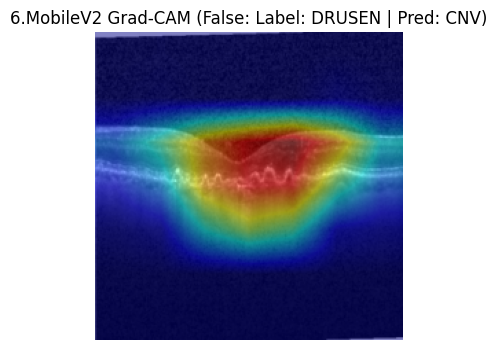

In [22]:
# pick incorrect in efficient
test_pred, test_true = evaluate_preds(
    model_mobile,
    test_loader,
    device
)

error_idx = (test_pred != test_true).nonzero(as_tuple=True)[0][0].item()

img, label = test_ds[error_idx]
pred_label = test_pred[error_idx].item()

input_tensor = img.unsqueeze(0).to(device)

run_gradcam(
    model_mobile,
    target_layer_mobile,
    input_tensor,
    title=f"6.MobileV2 Grad-CAM ({class_names[label] == class_names[pred_label]}: Label: {class_names[label]} | Pred: {class_names[pred_label]})"
)


In [23]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

def evaluate_all_metrics(model, loader, device):
    preds, labels = evaluate_preds(model, loader, device)

    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    macro_precision = precision_score(labels, preds, average="macro", zero_division=0)
    macro_recall = recall_score(labels, preds, average="macro", zero_division=0)

    cm = confusion_matrix(labels, preds)

    return acc, macro_f1, macro_precision, macro_recall, cm


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()



 ResNet-18 Metrics
Accuracy       : 0.9886
Macro-F1       : 0.9887
Macro-Precision: 0.9891
Macro-Recall   : 0.9886


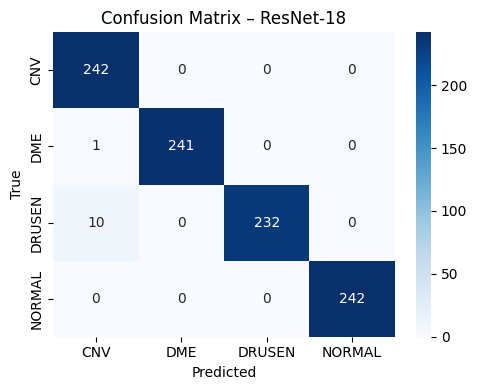

In [25]:
resnet_acc, resnet_f1, resnet_prec, resnet_rec, resnet_cm = \
    evaluate_all_metrics(model_resnet, test_loader, device)

print("\n ResNet-18 Metrics")
print(f"Accuracy       : {resnet_acc:.4f}")
print(f"Macro-F1       : {resnet_f1:.4f}")
print(f"Macro-Precision: {resnet_prec:.4f}")
print(f"Macro-Recall   : {resnet_rec:.4f}")

plot_confusion_matrix(
    resnet_cm,
    class_names,
    title="Confusion Matrix – ResNet-18"
)



 EfficientNet-B0 Metrics
Accuracy       : 0.9948
Macro-F1       : 0.9948
Macro-Precision: 0.9949
Macro-Recall   : 0.9948


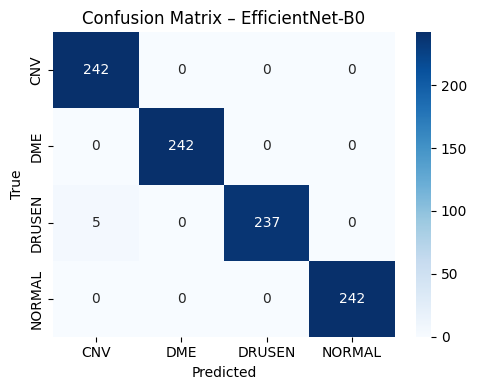

In [26]:
eff_acc, eff_f1, eff_prec, eff_rec, eff_cm = \
    evaluate_all_metrics(model_eff, test_loader, device)

print("\n EfficientNet-B0 Metrics")
print(f"Accuracy       : {eff_acc:.4f}")
print(f"Macro-F1       : {eff_f1:.4f}")
print(f"Macro-Precision: {eff_prec:.4f}")
print(f"Macro-Recall   : {eff_rec:.4f}")

plot_confusion_matrix(
    eff_cm,
    class_names,
    title="Confusion Matrix – EfficientNet-B0"
)



 MobileNetV2 Metrics
Accuracy       : 0.9897
Macro-F1       : 0.9897
Macro-Precision: 0.9901
Macro-Recall   : 0.9897


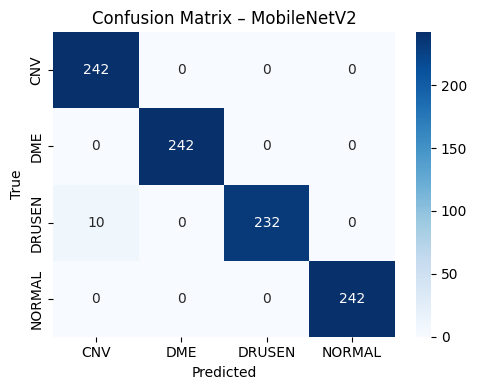

In [27]:
mobile_acc, mobile_f1, mobile_prec, mobile_rec, mobile_cm = \
    evaluate_all_metrics(model_mobile, test_loader, device)

print("\n MobileNetV2 Metrics")
print(f"Accuracy       : {mobile_acc:.4f}")
print(f"Macro-F1       : {mobile_f1:.4f}")
print(f"Macro-Precision: {mobile_prec:.4f}")
print(f"Macro-Recall   : {mobile_rec:.4f}")

plot_confusion_matrix(
    mobile_cm,
    class_names,
    title="Confusion Matrix – MobileNetV2"
)


In [28]:
import pandas as pd

metrics_table = pd.DataFrame([
    {
        "Model": "ResNet-18",
        "Accuracy": resnet_acc,
        "Macro-F1": resnet_f1,
        "Macro-Precision": resnet_prec,
        "Macro-Recall": resnet_rec
    },
    {
        "Model": "EfficientNet-B0",
        "Accuracy": eff_acc,
        "Macro-F1": eff_f1,
        "Macro-Precision": eff_prec,
        "Macro-Recall": eff_rec
    },
    {
        "Model": "MobileNetV2",
        "Accuracy": mobile_acc,
        "Macro-F1": mobile_f1,
        "Macro-Precision": mobile_prec,
        "Macro-Recall": mobile_rec
    }
])

metrics_table


,Model,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,ResNet-18,0.988636,0.988653,0.989130,0.988636
1,EfficientNet-B0,0.994835,0.994834,0.994939,0.994835
2,MobileNetV2,0.989669,0.989665,0.990079,0.989669
